In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
from pycaret.classification import *
import warnings
warnings.filterwarnings(action='ignore')

PATH = 'C:/Users/JYW/Desktop/Github/repository/Dacon/UserProblem_from_ServiceQuality_LG/data/'

## 1. Train_err

In [4]:
train_err = pd.read_csv(PATH+'train_err_data.csv')
print(train_err.shape)
train_err.head()

(16554663, 6)


,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


### 1-1. user_id

unique ids

In [ ]:
train_err.user_id.unique()

number of unique ids

In [6]:
len(train_err.user_id.unique())

15000

frequency of each ids
- right skewed

24934    222186
20546    195538
15570    175730
20352     83680
11041     66093
          ...  
19372         1
18544         1
20099         1
13198         1
12367         1
Name: user_id, Length: 15000, dtype: int64


(array([4.16679794e-04, 2.10635281e-05, 5.49091973e-06, 2.73045735e-06,
        1.08018093e-06, 9.00150775e-07, 5.70095491e-07, 1.80030155e-07,
        3.30055284e-07, 1.80030155e-07, 1.80030155e-07, 6.00100517e-08,
        6.00100517e-08, 0.00000000e+00, 3.00050258e-08, 3.00050258e-08,
        6.00100517e-08, 9.00150775e-08, 3.00050258e-08, 3.00050258e-08,
        3.00050258e-08, 3.00050258e-08, 3.00050258e-08, 6.00100517e-08,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.00050258e-08, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.00050258e-08, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

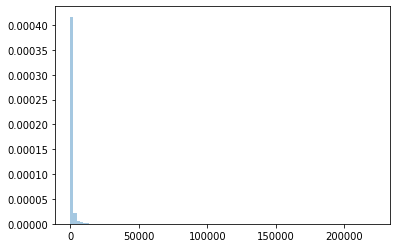

In [9]:
print(train_err.user_id.value_counts())
plt.hist(train_err.user_id.value_counts(), bins=100, density=True, alpha=0.4)

### 1-2. time

range of time

In [11]:
print(train_err.time.min())
print(train_err.time.max())

20201031235959
20201202185152


 frequency of time

(array([1.76678053e-13, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.08231693e-08, 2.15173727e-08, 3.46555061e-08, 3.84339076e-08,
        3.43098885e-08, 2.60514616e-08, 3.68559253e-08, 3.64515799e-08,
        2.05220393e-08, 3.91504785e-08, 3.72963130e-08, 2.90476034e-08,
        3.24943095e-08, 4.05303341e-08, 3.96394173e-08, 1.860819

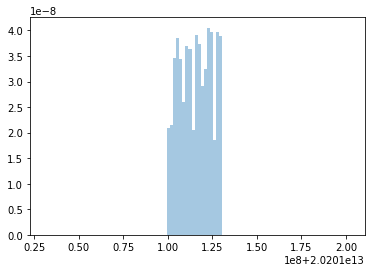

In [12]:
plt.hist(train_err.time, bins=100, density=True, alpha=0.4)

11월 8일 2시20분~32분이 right skewed의 주범

In [13]:
train_err.time.value_counts().head(15) 

20201108023257    631
20201108023253    585
20201108022122    526
20201108022121    521
20201108023256    490
20201108023254    420
20201107230752    418
20201108022120    417
20201108023250    395
20201108023251    387
20201108023252    368
20201108022123    348
20201108023258    318
20201108022124    239
20201108023255    237
Name: time, dtype: int64

### 1-3. model_nm

In [14]:
train_err.model_nm.unique()

array(['model_3', 'model_2', 'model_0', 'model_1', 'model_7', 'model_4',
       'model_5', 'model_8', 'model_6'], dtype=object)

In [15]:
train_err.model_nm.value_counts()

model_1    5384491
model_0    4176279
model_2    3473254
model_3    1907438
model_4    1507802
model_8      36064
model_7      35356
model_5      32233
model_6       1746
Name: model_nm, dtype: int64

### 1-4. fwver

In [17]:
print(len(train_err.fwver.unique()))
train_err.fwver.unique()

37


array(['05.15.2138', '04.33.1185', '04.33.1261', '04.22.1750',
       '04.22.1778', '04.16.3553', '04.33.1149', '04.16.3571',
       '05.66.3237', '05.66.3571', '03.11.1149', '04.22.1684',
       '03.11.1167', '04.82.1684', '04.82.1778', '04.33.1171',
       '04.73.2237', '10', '04.82.1730', '04.73.2571', '8.5.3',
       '04.22.1666', '03.11.1141', '05.15.2120', '04.33.1125',
       '04.16.3439', '04.22.1442', '04.33.1095', '04.16.3569',
       '05.15.2090', '05.15.3104', '05.15.2122', '04.22.1656',
       '04.16.2641', '05.15.2114', '04.16.3345', '05.15.2092'],
      dtype=object)

In [18]:
train_err.fwver.value_counts()

04.16.3553    5237816
04.22.1750    2874213
04.33.1261    2504871
05.15.2138    1906479
03.11.1167    1505659
04.22.1778    1293946
04.33.1185     963736
04.16.3571     145156
04.73.2237      33537
05.66.3237      31832
04.82.1684      23554
04.82.1778       8601
04.22.1684       5554
05.66.3571       3524
04.33.1149       3272
04.73.2571       2527
04.22.1442       2522
03.11.1149       2114
10               1534
04.16.3569        980
04.33.1095        909
05.15.2120        706
04.33.1125        408
04.16.2641        296
8.5.3             212
05.15.3104        191
04.16.3439        142
04.16.3345        101
04.82.1730         78
04.33.1171         58
04.22.1656         39
03.11.1141         29
05.15.2122         23
05.15.2092         18
05.15.2090         12
05.15.2114          9
04.22.1666          5
Name: fwver, dtype: int64

### 1-5. errtype

In [19]:
train_err.errtype.value_counts()

23    2276515
31    1985294
22    1865361
15    1604951
4     1296750
16    1249376
32    1130564
5      952920
40     730378
28     544306
27     540804
26     536401
12     320181
11     307030
14     252015
33     178477
34     165536
10     133403
41     104138
7       51993
6       50482
17      46009
24      39071
42      34374
3       30758
2       26106
13      22843
1       21545
39      15820
35      10187
37       9336
36       9317
38       4539
18       2671
20       2080
25       1184
19        664
21        607
30        402
8         166
9         109
Name: errtype, dtype: int64

(array([3.17425855e-03, 0.00000000e+00, 3.84623781e-03, 0.00000000e+00,
        4.53162424e-03, 0.00000000e+00, 0.00000000e+00, 1.91052206e-01,
        0.00000000e+00, 1.40395194e-01, 0.00000000e+00, 0.00000000e+00,
        7.43759201e-03, 0.00000000e+00, 7.66021000e-03, 0.00000000e+00,
        0.00000000e+00, 2.44570396e-05, 0.00000000e+00, 1.60591405e-05,
        0.00000000e+00, 1.96544726e-02, 0.00000000e+00, 0.00000000e+00,
        4.52352101e-02, 0.00000000e+00, 4.71727675e-02, 0.00000000e+00,
        0.00000000e+00, 3.36549492e-03, 0.00000000e+00, 3.71297641e-02,
        0.00000000e+00, 0.00000000e+00, 2.36459941e-01, 0.00000000e+00,
        1.84072520e-01, 0.00000000e+00, 0.00000000e+00, 6.77857793e-03,
        0.00000000e+00, 3.93522607e-04, 0.00000000e+00, 9.78281585e-05,
        0.00000000e+00, 0.00000000e+00, 3.06449653e-04, 0.00000000e+00,
        8.94302593e-05, 0.00000000e+00, 0.00000000e+00, 2.74826553e-01,
        0.00000000e+00, 3.35402515e-01, 0.00000000e+00, 0.000000

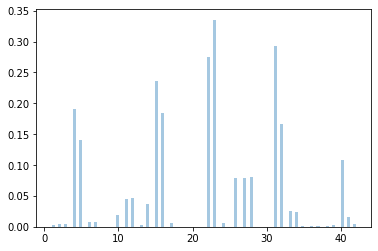

In [20]:
plt.hist(train_err.errtype, bins=100, density=True, alpha=0.4)

### 1-6. err_code

In [21]:
len(train_err.errcode.unique())

2806

In [22]:
train_err.errcode.value_counts()

1                     8906967
0                     2599123
connection timeout    1835600
B-A8002                897863
80                     334018
                       ...   
9288                        1
46679                       1
52668                       1
8172                        1
3476                        1
Name: errcode, Length: 2805, dtype: int64

대부분의 errcode가 1번씩 발생하나 엄청나게 많이 발생하는 코드들이 존재

{'whiskers': [<matplotlib.lines.Line2D at 0x215b27afe10>,
 'caps': [<matplotlib.lines.Line2D at 0x215b27bf400>,
 'boxes': [<matplotlib.lines.Line2D at 0x215b27afba8>],
 'medians': [<matplotlib.lines.Line2D at 0x215b27bf9b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x215b27bfc88>],
 'means': []}

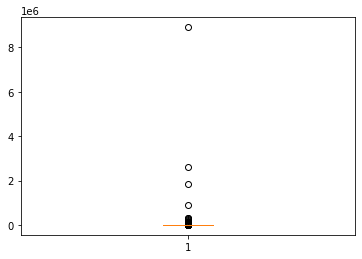

In [24]:
plt.boxplot(train_err.errcode.value_counts())

- - -

## 2. Train_quality

In [25]:
train_quality  = pd.read_csv(PATH+'train_quality_data.csv')
print(train_quality.shape)
train_quality.head()

(828624, 16)


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0


### 2-1. time

train_quality가 train_err의 전체 시간대를 커버하지 못한다.

In [26]:
print(train_quality.time.min())
print(train_quality.time.max())

20201031235000
20201130234000


train_quality의 time은 모두 10분 단위로 끊어져있다.

In [27]:
train_quality.time.value_counts()

20201110143000    948
20201110150000    876
20201110144000    864
20201110142000    828
20201110145000    828
                 ... 
20201103041000     12
20201123054000     12
20201113061000     12
20201129055000     12
20201108041000     12
Name: time, Length: 4319, dtype: int64

(array([2.63308837e-10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

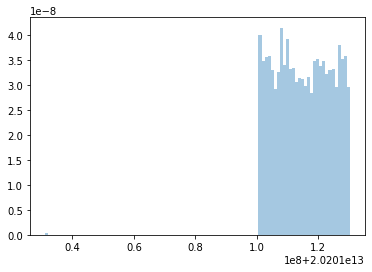

In [28]:
plt.hist(train_quality.time, bins=100, density=True, alpha=0.4)

### 2-2. fwver

In [29]:
train_quality.fwver.unique()

array(['05.15.2138', '04.22.1750', '04.16.3553', '04.33.1261',
       '04.22.1778', '04.33.1185', '04.16.3571', '05.66.3571',
       '03.11.1149', '03.11.1167', '04.82.1684', '04.82.1778',
       '04.33.1149', nan, '05.66.3237', '04.73.2237', '09.17.1431',
       '04.22.1684', '05.15.2120', '04.33.1125', '05.15.2122',
       '04.22.1666', '04.22.1656', '04.16.3439', '04.73.2571',
       '05.15.2114', '04.16.3345', '04.22.1442'], dtype=object)

train_err보다 더 적다

In [30]:
len(train_quality.fwver.unique())

28

In [31]:
train_quality.fwver.value_counts()

05.15.2138    163236
04.22.1750    142032
04.33.1261    131340
04.16.3553    111996
03.11.1167    104148
04.33.1185     66024
04.22.1778     56472
04.22.1684      3420
09.17.1431      3384
04.16.3571      2232
04.82.1684      1044
04.33.1149       804
04.22.1666       636
05.66.3237       552
04.82.1778       216
03.11.1149       204
04.73.2237       192
04.33.1125       144
05.66.3571        96
05.15.2114        96
04.22.1442        84
05.15.2120        84
05.15.2122        60
04.16.3439        12
04.16.3345        12
04.22.1656        12
04.73.2571        12
Name: fwver, dtype: int64

## 3. Train_problem

In [32]:
train_problem = pd.read_csv(PATH+'train_problem_data.csv')
print(train_problem.shape)
train_problem.head()

(5429, 2)


,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000


In [33]:
train_problem.user_id.value_counts()

24407    5
11016    4
20636    4
11528    4
24138    4
        ..
19613    1
19739    1
13596    1
15645    1
14311    1
Name: user_id, Length: 5000, dtype: int64

<AxesSubplot:>

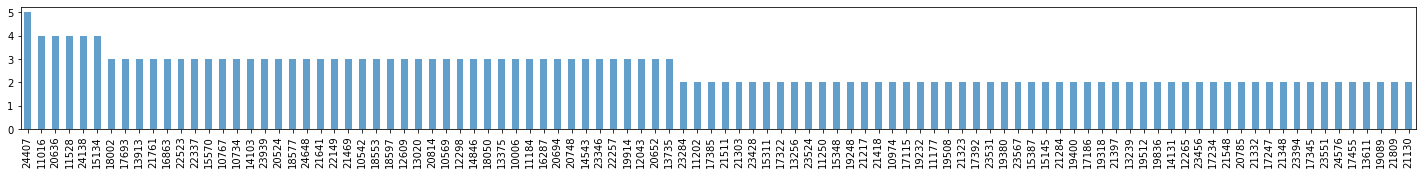

In [34]:
fig = plt.figure(figsize=(25,9))
plt.subplots_adjust(hspace=.5)
plt.subplot2grid((3,3), (0,0), colspan = 3)
train_problem['user_id'].value_counts()[:100].plot(kind='bar', alpha=0.7)

In [35]:
print(len(train_problem.user_id.value_counts()))
print(sum(train_problem.user_id.value_counts() > 1))
print(sum(train_problem.user_id.value_counts() <= 1))

5000
375
4625


전체 5,000명의 문제제기를 한 유저들 중 대부분이 1건만 문제제기를 했지만 375명의 2건 이상 제기를 한 사람도 존재한다.

이들에 대한 세부적인 특징을 반영한 분석이 필요할 듯